In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import glob
import re
import scipy
import requests
from matplotlib.patches import Rectangle
from datetime import datetime
# sns.set()

# Introduction <a id='intro'></a>

This notebook cleans and wrangles numerous data sets, making them uniform
so that they can be used in a data-driven model for COVID-19 prediction.

The key cleaning measures are those which find the most viable set of countries and date ranges
such that the maximal amount of data can be used. In other words, different datasets can have data
on a different set of countries; to avoid introducing large quantities of missing values
the intersection of these countries is taken.



# Table of contents<a id='toc'></a>

## [Data wrangling function definitions](#generalfunctions)

# Data <a id='data'></a>
data sources

To get the JHU CSSE data: git clone https://www.github.com/CSSEGISandData/COVID-19

To get the OWID data: git clone https://www.github.com/owid/covid-19-data/

To get and store OxCGRT government response data: git clone https://github.com/OxCGRT/covid-policy-tracker/

To get and store Test Tracker data, go to https://finddx.shinyapps.io/FIND_Cov_19_Tracker/
    
    Choose "Tests and cases" dataset, select "All" as the entry number, 
    save as test_tracker_cases_and_tests.csv in same directory as notebooks.
    
    
## [JHU CSSE case data.](#csse)
[https://systems.jhu.edu/research/public-health/ncov/](https://systems.jhu.edu/research/public-health/ncov/)

**Data available at:**
[https://github.com/CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/COVID-19)

This data is split between a collection of .csv files of two different formats; first, the daily reports (global) are
separated by day, each residing in their own .csv. Additionally, the daily report files have three different formats that need to be taken into account when compiling the data. The daily report data itself contains values on the number of confirmed cases, deceased, active cases, recovered cases.

For the other format, .csv files with 'timeseries' in their filename, the data contains values for confirmed, deceased, recovered and are split between global numbers (contains United States as a whole) and numbers for the united states (statewide).
           
           
## [OWID case and test data](#owid)

**Data available via github**
[https://github.com/owid/covid-19-data](https://github.com/owid/covid-19-data)

[https://ourworldindata.org/covid-testing](https://ourworldindata.org/covid-testing)

The OWID dataset contains information regarding case and test numbers; it overlaps with the JHU CSSE 
and Testing Tracker datasets but I am going to attempt to use it in conjunction with those two because
of how there is unreliable reporting. In other words to get the bigger picture I'm looking to stitch together
multiple datasets.

           
## [OxCGRT government response data](#oxcgrt)

**Data available at:**
[https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv](https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv)


[https://github.com/OxCGRT/covid-policy-tracker/](https://github.com/OxCGRT/covid-policy-tracker/)

The OxCGRT dataset contains information regarding different government responses in regards to social
distancing measures. It measures the type of social distancing measure, whether or not they are recommended
or mandated, whether they are targeted or broad (I think geographically). 
           
## [Testing tracker data](#testtrack)
<!-- **Website which lead me to dataset**
[https://www.statista.com/statistics/1109066/coronavirus-testing-in-europe-by-country/](https://www.statista.com/statistics/1109066/coronavirus-testing-in-europe-by-country/) -->

**Data available at:**
[https://finddx.shinyapps.io/FIND_Cov_19_Tracker/](https://finddx.shinyapps.io/FIND_Cov_19_Tracker/)

This dataset contains a time series of testing information: e.g. new (daily) tests, cumulative tests, etc. 


# [Data regularization: making things uniform](#uniformity)

### [Intersection of countries](#country)
  
### [Time series date ranges](#time)

### [Missing Values](#missingval)

## Data wrangling function declaration <a id='generalfunctions'></a>


In [2]:

def country_slice(data, locations):
    if type(locations)==str:
        return data[data.location==locations]
    else:
        return data[data.location.isin(locations)]
    
def time_slice(data, start, end, indexer='time_index'):
    if start < 0 and end < 0:
        start =data.loc[:, indexer].max()+start
        end = data.loc[:, indexer].max()+end
    return data[(data.loc[:, indexer] >= start) & (data.loc[:, indexer] <= end)]

def country_search(df, country):
    return df[df.location==country].index

def country_groupby(df):
    return [df[df.location==country].index for country in df.location.unique()]


def column_search(df, name, return_style='loc', threshold='contains'):
    if threshold=='contains':
        func = df.columns.str.contains
    else:
        func = df.columns.str.match
        
    if return_style == 'loc':
        return df.columns[func(name)]
    elif return_style== 'iloc':
        return np.where(func(name))[0]
    else:
        return None


def reformat_values(values_to_transform, category='columns',dateformat=None):
    """ Reformat column and index names. 
    
    Parameters :
    ----------
    df : Pandas DataFrame
    columns : bool
    index : bool|
    
    Notes :
    -----
    Change headers of columns; this needs to be updated to account for their formatting changes. 
    This function converts strings with CamelCase, underscore and space separators to lowercase words uniformly
    separated with underscores. I.e. (hopefully!) following the correct python identifier syntax so that each column
    can be reference as an attribute if desired. 

    For more on valid Python identifiers, see:
    https://docs.python.org/3/reference/lexical_analysis.html#identifiers
    """
    
    """ Reformat column and index names. only works with with pandas MultiIndex for level=0.
    
    Parameters :
    ----------
    df : Pandas DataFrame

    Notes :
    -----
    Different datasets have different naming conventions (for countries that go by multiple names and abbreviations).
    This function imposes a convention on a selection of these country names.  
    """
    # these lists are one-to-one. countries compared via manual inspection, unfortunately. 
    mismatch_labels_bad = ['Lao People\'s Democratic Republic', 'Mainland China',
                           'Occupied Palestinian Territory','Republic of Korea', 'Korea, South', 
                           'Gambia, The ', 'UK', 
                           'USA', 'Iran (Islamic Republic of)',
                           'Bahamas, The', 'Russian Federation', 'Czech Republic', 'Republic Of Ireland',
                          'Hong Kong Sar', 'Macao Sar', 'Uk','Us',
                           'Congo ( Kinshasa)','Congo ( Brazzaville)',
                           'Cote D\' Ivoire', 'Viet Nam','Guinea- Bissau','Guinea','Usa']

    mismatch_labels_good = ['Laos','China',
                            'Palestine', 'South Korea', 'South Korea', 
                            'The Gambia', 'United Kingdom', 
                            'United States','Iran',
                            'The Bahamas','Russia','Czechia','Ireland',
                            'Hong Kong','Macao','United Kingdom', 'United States',
                            'Democratic Republic Of The Congo','Republic Of The Congo',
                            'Ivory Coast','Vietnam', 'Guinea Bissau','Guinea Bissau','United States']
    
    # three cases, column names, country names, or datetime. 
    if category == 'location':
        reformatted_values = []
        for val in values_to_transform:
            reformatted_values.append(' '.join(re.sub('([A-Z][a-z]+)', r' \1', 
                                                        re.sub('([A-Z]+)|_|\/|\)|\(', r' \1', val).lower())
                                                        .split()).title())
        transformed_values = pd.Series(reformatted_values).replace(to_replace=mismatch_labels_bad, value=mismatch_labels_good)
    
    elif category == 'columns':
        reformatted_values = []
        for val in values_to_transform:
            reformatted_values.append('_'.join(re.sub('([A-Z][a-z]+)', r' \1', 
                                                     re.sub('([A-Z]+)|_|\/|\)|\(', r' \1', val)
                                                            .lower()).split()))
        transformed_values = pd.Series(reformatted_values)
        
    elif category == 'date':
        transformed_values = pd.to_datetime(pd.Series(
            values_to_transform), errors='coerce',format=dateformat).dt.normalize()


    return transformed_values

def per_country_plot(data, feature, legend=True):
    data.set_index(['time_index', 'location']).loc[:, feature].unstack().plot(legend=legend)
    return None

def per_time_plot(data, feature, legend=True):
    data.set_index(['location','time_index']).loc[:, feature].unstack().plot(legend=legend)
    return None

In [3]:
#----------------- Helper Functions for cleaning ----------------------#


#----------------- Helper Functions for regularization ----------------------#
def intersect_country_index(df, country_intersection):
    df_tmp = df.copy().reset_index(level=0)
    df_tmp = df_tmp[df_tmp.location.isin(country_intersection)]
    df_tmp = df_tmp.set_index(['location', df_tmp.index])
    return df_tmp 

def resample_dates(df, dates):
    df = df.loc[~df.index.duplicated(keep='first')]
    return df.reindex(pd.MultiIndex.from_product([df.index.levels[0], dates], names=['location', 'date']), fill_value=np.nan)

def make_multilevel_columns(df):
    df.columns = pd.MultiIndex.from_product([[df.columns.name], df.columns], names=['dataset', 'features'])
    return df

def multiindex_to_table(df):
    df_table = df.copy()
    try:
        df_table.columns = df_table.columns.droplevel()
        df_table.columns.names = ['']
    except:
        pass
    df_table = df_table.reset_index()
    return df_table

#----------------- Manipulation flagging ----------------------#


def regularize_names(df, datekey=None, locationkey=None, dateformat=None):
    df.columns = reformat_values(df.columns, category='columns').values
    if datekey is not None:
        df.loc[:, 'date'] = reformat_values(df.loc[:, datekey], category='date', dateformat=None).values
    if locationkey is not None:
        df.loc[:, 'location'] =  reformat_values(df.loc[:, locationkey], category='location').values
    return df



def add_time_indices(data_table, index_column='cases'):
    indexer = ((data_table.loc[:, ['location', index_column]].replace(to_replace=np.nan, value=0)
               ).replace(to_replace=0, value=np.nan).dropna().reset_index()
              )
    country_groupby_indices = country_groupby(data_table)
    country_groupby_indices_dropped_nan = country_groupby(indexer)
    days_since = []
    for i, c in enumerate(country_groupby_indices_dropped_nan):
        nonzero_list = list(range(len(c)))
        zero_list = 0*np.array(list(range(len(country_groupby_indices[i])-len(c))))
        days_since += list(zero_list)+nonzero_list

    data_table.loc[:, 'days_since_first_case'] = days_since
    data_table.loc[:, 'time_index'] = len(data_table.location.unique())*list(range(len(data_table.date.unique())))
    return data_table


def regularize_time_series(df_list, location_operation='intersection', date_operation='union'):
    locations = df_list[0].index.levels[0].unique()
    dates =  df_list[0].index.levels[1].unique()
    for i in range(len(df_list)-1):
        if location_operation == 'intersection':
            locations = locations.intersection(df_list[i+1].index.levels[0].unique())
        # not really intersection, this is the minimum date that at least one locations has data for, in each dataset.
        elif location_operation == 'union':
            locations = locations.union(df_list[i+1].index.levels[0].unique())
            
        if date_operation == 'intersection':
            dates = dates.intersection(df_list[i+1].index.levels[1].unique())
        elif date_operation == 'union':
            dates = dates.union(df_list[i+1].index.levels[1].unique())
    df_list = [intersect_country_index(df, locations) for df in df_list]
    #This redefines the time series for all variables as from December 31st 2019 to the day with most recent data
    time_normalized_global_data = [resample_dates(df, dates.normalize()) for df in df_list]
    # To keep track of which data came from where, make the columns multi level with the first level labelling the dataset.
    return time_normalized_global_data, dates, locations

def rolling_features(df, features, roll_widths):
    new_feature_df_list = []
    for window in roll_widths:
        # order the dataframe so date is index, backfill in the first roll_width values
        rollmean = None
        rollstd = None
        for c in country_groupby(df):
            if rollmean is None:
                rollmean = df.loc[c, features].rolling(window).mean().fillna(value=0.)
                rollstd = df.loc[c, features].rolling(window).std().fillna(value=0.)
            else:
                rollmean = pd.concat((rollmean,  df.loc[c,features].rolling(window).mean().fillna(value=0.)),axis=0)
                rollstd = pd.concat((rollstd,  df.loc[c,features].rolling(window).std().fillna(value=0.)),axis=0)

        new_features = pd.concat((rollmean, rollstd), axis=1)
#         new_features = rollmean
#         new_cols = pd.Index(features) +'_rolling_mean_' + str(window)
#         new_cols = mean_cols

        mean_cols = pd.Index(features) +'_rolling_mean_' + str(window)
        std_cols = pd.Index(features) +'_rolling_std_' + str(window)
        new_cols = mean_cols.append(std_cols)
        new_features.columns = new_cols
        new_feature_df_list.append(new_features)
    return pd.concat(new_feature_df_list,axis=1)



def tsplot(pd_series, roll_width, **kw):
    fig, ax = plt.subplots(figsize=(10,5))
    rollmean = pd_series.rolling(roll_width).mean().fillna(method='backfill').values.ravel()
    rollstd  = pd_series.rolling(roll_width).std().fillna(method='backfill').values.ravel()
    cis = (rollmean - rollstd, rollmean + rollstd)
    ax.fill_between(range(len(pd_series)), cis[0], cis[1], alpha=0.5)
    ax.plot(range(len(pd_series)), rollmean, color='k')
    return ax



def regularize_names(df, datekey=None, locationkey=None, dateformat=None):
    df.columns = reformat_values(df.columns, category='columns').values
    if datekey is not None:
        df.loc[:, 'date'] = reformat_values(df.loc[:, datekey], category='date', dateformat=None).values
    if locationkey is not None:
        df.loc[:, 'location'] =  reformat_values(df.loc[:, locationkey], category='location').values
    return df


def fix_incorrect_decrease(df, feature, search_threshold='match'):
    df_tmp = df.copy()
    matching_columns = column_search(df_tmp, feature, return_style='iloc', threshold=search_threshold) 
    feature_index =  matching_columns[df_tmp.iloc[:, matching_columns].isna().sum().argmin()]
    location_index =  column_search(df_tmp, 'location', return_style='iloc', threshold=search_threshold)[0] 
    decreasing_indices = np.where(df_tmp.iloc[:, [location_index, feature_index]].groupby('location').diff(1)< 0)[0].ravel()
    n_countries_with_missing = len(df_tmp.iloc[decreasing_indices, location_index].unique().tolist())
    print('Fixing {} countries in the ''{}'' column feature'.format(
        n_countries_with_missing, df_tmp.iloc[:, feature_index].name)) 
    # premptive filling, not related to decreasing but rather missing values.
    decreasing_incorrectly = []
    flag = True
    
    # flag is switched off immediately, but will be switched on if any values are changed.
    df_tmp.iloc[:, feature_index] = df_tmp.iloc[:, [location_index, feature_index]].groupby('location').fillna(method='ffill')
    df_tmp.iloc[:, feature_index] = df_tmp.iloc[:, [location_index, feature_index]].groupby('location').fillna(0)
    while flag:
        flag = False
        decreasing_indices = np.where(df_tmp.iloc[:, [location_index, feature_index]].groupby('location').diff(1)< 0)[0].ravel()
        if decreasing_indices.size > 0:
            countries_with_missing = df_tmp.iloc[decreasing_indices, location_index].unique().tolist()
            flag = True
            df_tmp.iloc[decreasing_indices, feature_index] = np.nan
            df_tmp.iloc[:, feature_index] = df_tmp.iloc[:, [location_index, feature_index]].groupby('location').fillna(method='ffill')
            df_tmp.iloc[:, feature_index] = df_tmp.iloc[:, [location_index, feature_index]].groupby('location').fillna(0)
    return df_tmp

def rolling_means(df, features, roll_widths):
    new_feature_df_list = []
    for window in roll_widths:
        # order the dataframe so date is index, backfill in the first roll_width values
        rollmean = None
        for c in country_groupby(df):
            if rollmean is None:
                rollmean = df.loc[c, features].rolling(window).mean().fillna(value=0.)
            else:
                rollmean = pd.concat((rollmean,  df.loc[c,features].rolling(window).mean().fillna(value=0.)),axis=0)
        new_features = rollmean
        new_cols = pd.Index(features) +'_rolling_mean_' + str(window)

        new_features.columns = new_cols
        new_feature_df_list.append(new_features)
    return new_feature_df_list


def new_average_feature(data, features, new_feature_name):
    data.loc[:, new_feature_name] = data.loc[:, features].mean(1).fillna(0).values
    return None

## Data Reformatting

The following sections take the corresponding data set and reformat them such that the data
is stored in a pandas DataFrame with a multiindex; level=0 -> 'location' (country or region) and
level=1 -> date. Due to the nature of the data this is done separately for country-wide and united states-wide locations.
Eventually for the data exploration, these data are combined and then exported.

Additionally, the reformatted data are saved/exported separately in-case I desire future use outside of this notebook.

## JHU CSSE case data
<a id='csse'></a>
[Return to table of contents](#toc)

In [4]:
global_df_list = []

for x in glob.glob('COVID-19/csse_covid_19_data/csse_covid_19_time_series/*_global.csv'):
    tmp_df = pd.read_csv(x)
    catcols = tmp_df.iloc[:, :4]
    datecols = tmp_df.iloc[:, 4:]
    catcols.columns = reformat_values(catcols.columns, category='columns').values
    catcols.loc[:, 'location'] =  reformat_values(catcols.loc[:, 'country_region'], category='location').values
    datecols.columns = reformat_values(datecols.columns, category='date').values
    global_tmp = pd.concat((catcols.location,datecols),axis=1).groupby(by='location').sum().sort_index()
    # keep the name of the data; i.e. 'confirmed', 'deaths', etc.
    time_series_name = x.split('.')[0].split('_')[-2]
    global_df_list.append(global_tmp.stack().to_frame(name=time_series_name))

# Rename the columns
csse_global_time_series_df = pd.concat(global_df_list, axis=1)
csse_global_time_series_df.index.names = ['location','date']
csse_global_time_series_df.columns.names = ['csse_global_timeseries']
csse_global_time_series_df.columns = ['cases', 'deaths', 'recovered']
csse_global_time_series_df = csse_global_time_series_df.reset_index()

# Do the country georgia separately in-case data ever contains U.S. states info.
geor_index = csse_global_time_series_df[csse_global_time_series_df.location=='Georgia'].index
csse_global_time_series_df.loc[geor_index, 'location'] = 'Sakartvelo' 
csse_global_time_series_df.loc[:, 'date'] = pd.to_datetime(csse_global_time_series_df.loc[:,'date']).values
csse_global_time_series_df = csse_global_time_series_df.set_index(['location', 'date'])
csse_global_time_series_df.to_csv('jhucsse_global.csv')

In [5]:
csse_global_time_series_df.sample(5)

,,cases,deaths,recovered
location,date,,,
Laos,2020-05-26,19,0,14
Bhutan,2020-05-22,21,0,6
Madagascar,2020-02-11,0,0,0
Barbados,2020-06-12,96,7,83
Iceland,2020-01-31,0,0,0


In [6]:
usa_df_list = []
for x in glob.glob('COVID-19/csse_covid_19_data/csse_covid_19_time_series/*_US.csv'):
    tmp_df = pd.read_csv(x)
    catcols = tmp_df.iloc[:, :np.where(tmp_df.columns == '1/22/20')[0][0]]
    catcols.columns = reformat_values(catcols.columns, category='columns').values
    catcols.loc[:, 'location'] =  catcols.loc[:, 'province_state'].values
    
    datecols = tmp_df.iloc[:,np.where(tmp_df.columns == '1/22/20')[0][0]:]
    datecols.columns = reformat_values(datecols.columns, category='date').values
    usa_tmp = pd.concat((catcols.location,datecols),axis=1).groupby(by='location').sum().sort_index()
    # keep the name of the data; i.e. 'confirmed', 'deaths', etc.
    time_series_name = x.split('.')[0].split('_')[-2]
    usa_df_list.append(usa_tmp.stack().to_frame(name=time_series_name))
    
csse_usa_time_series_df = pd.concat(usa_df_list,axis=1)#.reset_index(drop=True)
csse_usa_time_series_df.index.names = ['location','date']
csse_usa_time_series_df.columns.names = ['csse_us_timeseries']
csse_usa_time_series_df.columns = ['cases', 'deaths']
csse_usa_time_series_df = csse_usa_time_series_df.reset_index()

csse_usa_time_series_df.loc[:, 'date'] = pd.to_datetime(csse_usa_time_series_df.loc[:,'date']).values
csse_usa_time_series_df = csse_usa_time_series_df.set_index(['location', 'date'])
csse_usa_time_series_df.to_csv('jhucsse_usa.csv')

In [7]:
csse_usa_time_series_df.sample(5)

,,cases,deaths
location,date,,
Arizona,2020-06-02,21264,943
Northern Mariana Islands,2020-05-10,16,2
Alabama,2020-04-13,3734,99
Utah,2020-05-15,6913,77
Iowa,2020-05-02,8643,175


## OWID case and test data
<a id='source5'></a>
[Return to table of contents](#toc)

The "Our World in Data" dataset contains time series information on the cases, tests, and deaths.

It is important to note that confirmed in owid cases is less than total 

In [8]:
owid_df =pd.read_csv('./covid-19-data/public/data/owid-covid-data.csv')
owid_df = regularize_names(owid_df, datekey='date', locationkey='location').set_index(['location', 'date']).sort_index()
owid_df.to_csv('owid.csv')

In [9]:
owid_df.sample(5)

,,iso_code,continent,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
location,date,,,,,,,,,,,,,,,,,,,,,
Peru,2020-05-23,PER,South America,111698.0,2929.0,3244.0,96.0,3387.678,88.833,98.387,2.912,...,4.455,12236.706,3.5,85.755,5.95,4.8,NaN,NaN,1.6,76.74
Fiji,2020-03-23,FJI,Oceania,3.0,1.0,0.0,0.0,3.347,1.116,0.000,0.000,...,3.284,8702.975,1.4,412.820,14.49,10.2,34.8,NaN,2.3,67.44
Nepal,2020-01-25,NPL,Asia,1.0,1.0,0.0,0.0,0.034,0.034,0.000,0.000,...,3.212,2442.804,15.0,260.797,7.26,9.5,37.8,47.782,0.3,70.78
Sint Maarten Dutch Part,2020-04-26,SXM,North America,73.0,0.0,12.0,0.0,1702.346,0.000,279.838,0.000,...,NaN,36327.232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.95
Argentina,2020-05-11,ARG,South America,5776.0,13.0,300.0,0.0,127.800,0.288,6.638,0.000,...,7.441,18933.907,0.6,191.032,5.50,16.2,27.7,NaN,5.0,76.67


## OxCGRT government response data
<a id='oxcgrt'></a>
[Return to table of contents](#toc)

Manual importation of data (for whatever reason this data set is different from pulling using API). This
dataset contains time series information for the different social distancing and quarantine measures. The time
series are recorded using flags which indicate whether or not a measure is in place, recommended, or not considered.
In addition, there are addition flags which augment these time series; indicating whether or not the measures are targeted
or general.

In [10]:
oxcgrt_df = regularize_names(pd.read_csv('./covid-policy-tracker/data/OxCGRT_latest.csv'), locationkey='country_name')
oxcgrt_df.loc[:, 'date'] = pd.to_datetime(oxcgrt_df.loc[:, 'date'], format='%Y%m%d')
oxcgrt_df = oxcgrt_df.set_index(['location', 'date'])
oxcgrt_df.to_csv('oxcgrt.csv')

In [11]:
oxcgrt_df.sample(5)

,,country_name,country_code,c1_school_closing,c1_flag,c2_workplace_closing,c2_flag,c3_cancel_public_events,c3_flag,c4_restrictions_on_gatherings,c4_flag,...,stringency_index,stringency_index_for_display,stringency_legacy_index,stringency_legacy_index_for_display,government_response_index,government_response_index_for_display,containment_health_index,containment_health_index_for_display,economic_support_index,economic_support_index_for_display
location,date,,,,,,,,,,,,,,,,,,,,,
Brunei,2020-05-18,Brunei,BRN,3.0,1.0,0.0,NaN,1.0,1.0,3.0,1.0,...,52.78,52.78,63.81,63.81,47.44,47.44,53.79,53.79,12.5,12.5
Dominican Republic,2020-06-09,Dominican Republic,DOM,3.0,1.0,2.0,1.0,2.0,1.0,3.0,1.0,...,78.70,78.70,82.14,82.14,67.31,67.31,75.00,75.00,25.0,25.0
Zimbabwe,2020-02-27,Zimbabwe,ZWE,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,...,8.33,8.33,13.10,13.10,5.77,5.77,6.82,6.82,0.0,0.0
Sudan,2020-03-06,Sudan,SDN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,...,5.56,5.56,9.52,9.52,3.85,3.85,4.55,4.55,0.0,0.0
Aruba,2020-03-27,Aruba,ABW,3.0,1.0,2.0,1.0,0.0,NaN,0.0,NaN,...,41.67,41.67,57.14,57.14,35.26,35.26,41.67,41.67,0.0,0.0


Reformat the data, making it a multiindex dataframe which matches the others in this notebook. Also, cast
the date-like variable as a datetime feature.

## Testing tracker data
<a id='testtrack'></a>
[Return to table of contents](#toc)

In [12]:
test_tracker = regularize_names(pd.read_csv('test_tracker_cases_and_tests.csv'),
                          datekey='date', locationkey='country').set_index(
                            ['location', 'date']).drop(
                                    columns=['country','population','alpha3']).sort_index()
test_tracker.to_csv('test_tracker.csv')

In [13]:
test_tracker.sample(5)

,,new_tests,tests_cumulative,tests_per100k,source,cases,new_cases,deaths,cases_per100k,deaths_per100k,income_group,continent,region
location,date,,,,,,,,,,,,
United States,2020-06-28,590877.0,30401644.0,9184.7,https://covidtracking.com/data/#ME,2548996.0,38845.0,125803.0,770.1,38.0,High income,North America,Northern America
Western Sahara,2020-05-20,0.0,4.0,0.7,https://africacdc.org/covid-19/,6.0,0.0,0.0,1.0,0.0,NaN,Africa,Northern Africa
Cambodia,2020-03-10,NaN,NaN,NaN,NaN,2.0,0.0,0.0,0.0,0.0,Lower middle income,Asia,South-eastern Asia
Nicaragua,2020-04-05,NaN,NaN,NaN,NaN,6.0,1.0,1.0,0.1,0.0,Lower middle income,North America,Central America
Taiwan,2020-05-24,183.0,70880.0,297.6,https://www.cdc.gov.tw/En,441.0,0.0,7.0,1.9,0.0,High income,Asia,Eastern Asia


## Data regularization: making things uniform <a id='uniformity'></a>

## Intersection of countries in all DataFrames
<a id='country'></a>
[Return to table of contents](#toc)

The data that will be used to model country-wide case numbers exists in the DataFrames : 

    csse_global_timeseries_df
    owid_df
    oxcgrt_df
    testtrack_df
    
The index (locations) were not reformatted by default; do that now.

The data have all been formatted to have multi level indices and columns; the levels of the index are ```['location', 'date']``` which correspond to geographical location and day of record. To process/merge these dataframes, I find it convenient to put these DataFrames into a list and then normalize the countries and dates by iterating over them. For exploration purposes, the similarly named (i.e. redundant) features are kept separate by adding a suffix corresponding to the dataset from which they originate.

The next step is to find the subset of all countries which exist in all of the DataFrames. It is possible to
simply concatenate the data and introduce missing values, however, I am electing to take the intersection of countries as
to take the most "reliable" subset. On the contrary, for the dates I take the union; that is, the dates that exist in all datasets. 

# Data preprocessing and exploration

## Regularization of time series dates
<a id='time'></a>
[Return to table of contents](#toc)

In [14]:
all_data = [csse_global_time_series_df,csse_usa_time_series_df, test_tracker, oxcgrt_df, owid_df]
global_data = [csse_global_time_series_df, test_tracker, oxcgrt_df, owid_df]

In [15]:
names = ['jhucsse', 'jhucsse_usa', 'testtracker',  'oxcgrt', 'owid']
export_list = []

export_list_tmp, dates_intersection, country_intersection = regularize_time_series(all_data, location_operation='union',
                                                                                  date_operation='intersection')

for i, x in enumerate(export_list_tmp):
    gd_export_copy = x.copy()
    gd_export_copy.columns += '_' + names[i]
    export_list.append(gd_export_copy)
    
eda_data = multiindex_to_table(pd.concat(export_list, axis=1))
eda_data = eda_data[~eda_data.location.isin(['Diamond Princess','World'])]

print('The range of all dates is from {} to {}'.format(dates_intersection.min(), dates_intersection.max()))
print('The final number of locations included is {}'.format(len(country_intersection)))

The range of all dates is from 2020-01-22 00:00:00 to 2020-06-28 00:00:00
The final number of locations included is 296


By using multiple datasets, there is redundant information for cases, tests, deaths, etc. I average
over these values to account for errors and differences in reporting, using the philosophy that
it is better to aggregate as much data as possible, at the very least for exploration.

In [16]:
death_columns = ['deaths_jhucsse', 'deaths_jhucsse_usa']
new_average_feature(eda_data, death_columns, 'total_deaths')

In [17]:
case_columns = ['cases_jhucsse', 'cases_jhucsse_usa', 'cases_testtracker',
       'confirmed_cases_oxcgrt', 'total_cases_owid']
new_average_feature(eda_data, case_columns, 'total_cases')

In [18]:
test_columns =  [ 'tests_cumulative_testtracker','total_tests_owid']
new_average_feature(eda_data, test_columns, 'total_tests')

If there are any countries without any information on the total cases, then they are dropped
due to lack of utility.

In [19]:
locations_with_no_case_data = eda_data.location[~eda_data.location.isin(
    eda_data.loc[eda_data.total_cases.replace(to_replace=[0,0.], value=np.nan
                                             ).dropna().index,'location'].unique())].unique()

Drop the "bad" countries and then create new time-index features. Time index is an integer counting feature which spans
the range of dates printed out above.

In [20]:
eda_data = eda_data[~(eda_data.location.isin(locations_with_no_case_data))]
eda_data = add_time_indices(eda_data, index_column='total_cases')

Look at the top five total countries deaths, tests, cases, time series to get an idea as to the condition of the data.

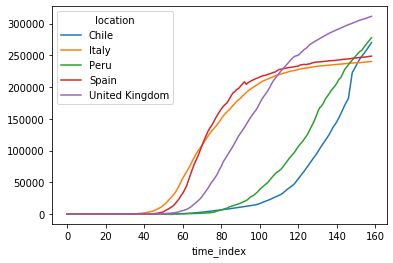

In [21]:
eda_data[eda_data.location.isin(eda_data.set_index(['time_index', 'location']).total_cases.groupby(level=1).max().sort_values()[-10:-5].index)].set_index(['time_index', 'location']).total_cases.unstack().plot()

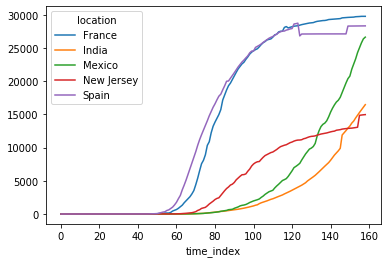

In [22]:
eda_data[eda_data.location.isin(
                                 (eda_data.set_index(['time_index', 'location']).total_deaths
                                 ).groupby(level=1).max().sort_values()[-10:-5].index
                               )].set_index(['time_index', 'location']).total_deaths.unstack().plot()

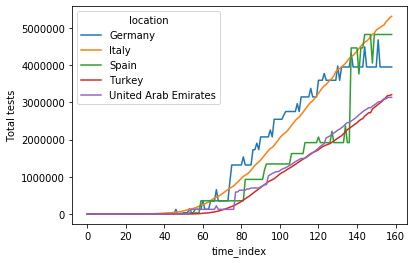

In [23]:
eda_data[eda_data.location.isin(eda_data.set_index(['time_index', 'location']).total_tests.groupby(level=1).max().sort_values()[-10:-5].index)].set_index(['time_index', 'location']).total_tests.unstack().plot()
_ = plt.ylabel('Total tests')

In [24]:
for features in ['total_tests', 'total_cases', 'total_deaths']:
    eda_data = fix_incorrect_decrease(eda_data, features, search_threshold='match')

Fixing 68 countries in the total_tests column feature
Fixing 59 countries in the total_cases column feature
Fixing 46 countries in the total_deaths column feature


Label the columns with the data sources because otherwise there are repeated column names which is a pain to deal with
later on.

In [25]:
for country_indices in country_groupby(eda_data):
    eda_data.loc[country_indices, column_search(eda_data,'population')] = \
    eda_data.loc[country_indices,  column_search(eda_data,'population')].fillna(method='ffill').fillna(method='bfill').values 

In [26]:
death_copy = eda_data.iloc[:,3].copy()
eda_data = eda_data.drop(columns=['deaths_jhucsse'])
eda_data = pd.concat((eda_data.iloc[:,:3], death_copy,eda_data.iloc[:,4:]),axis=1)

Calculate moving averages here to save space in exploration notebook.

In [27]:
# use multiples of 7 to capture weekly seasonality
roll_widths = [3, 7, 14, 21, 28]

new_features = rolling_features(eda_data, 
                                  eda_data.select_dtypes(include='number').columns, 
                                  roll_widths=roll_widths)

Concatenate these new features and then export data.

In [28]:
export_to_modeling = pd.concat((eda_data,
                                new_features
                               ),axis=1)

export_to_modeling.loc[:, export_to_modeling.select_dtypes(include='object').columns] = \
export_to_modeling.loc[:, export_to_modeling.select_dtypes(include='object').columns].fillna('Missing')

tmp = eda_data.loc[:, column_search(eda_data, 'total').tolist()+['location']].groupby('location').diff(1).fillna(0)
tmp.columns = 'new_' + tmp.columns
tmp.sample(5)

,new_total_cases_owid,new_total_deaths_owid,new_total_cases_per_million_owid,new_total_deaths_per_million_owid,new_total_tests_owid,new_total_tests_per_thousand_owid,new_total_deaths,new_total_cases,new_total_tests
29053,0.0,0.0,0.000,0.0,0.0,0.000,4.0,80.000000,0.0
2302,7.0,0.0,65.564,0.0,0.0,0.000,0.0,7.000000,0.0
24931,19.0,0.0,35.150,0.0,797.0,1.474,0.0,43.666667,797.0
18291,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.000000,0.0
31610,0.0,0.0,0.000,0.0,0.0,0.000,4.0,65.000000,0.0


In [29]:
tmp_per_mill = tmp / np.tile((eda_data.population_owid.values.reshape(-1,1)/1000000.),(1,9))
tmp_per_mill.columns += '_per_million'

pd.concat((export_to_modeling, tmp, tmp_per_mill),axis=1).to_csv('data.csv')

The process above is repeated for the data which will be used in the CNN and regression models,
respectively. This is done separately to avoid mistakes.

In [30]:
names = ['jhucsse', 'testtracker',  'oxcgrt', 'owid']
export_list = []

export_list_tmp, dates_intersection, country_intersection = regularize_time_series(global_data, 
                                                                                   location_operation='intersection',
                                                                                  date_operation='intersection')

for i, x in enumerate(export_list_tmp):
    gd_export_copy = x.copy()
    gd_export_copy.columns += '_' + names[i]
    export_list.append(gd_export_copy)
    
data = add_time_indices(multiindex_to_table(pd.concat(export_list, axis=1)), index_column='cases_jhucsse')
data = data[~data.location.isin(['Diamond Princess','World'])]
print('The range of all dates is from {} to {}'.format(dates_intersection.min(), dates_intersection.max()))
print('The final number of locations included is {}'.format(len(country_intersection)))

The range of all dates is from 2020-01-22 00:00:00 to 2020-06-28 00:00:00
The final number of locations included is 149


In [31]:
dataframe_list, modeling_dates, modeling_countries = regularize_time_series(global_data, location_operation='intersection',
                                                                                  date_operation='intersection')
print('The range of all dates is from {} to {}'.format(modeling_dates.min(), modeling_dates.max()))
print('The number of countries included is {}'.format(len(modeling_countries)))
# Convert the multiindex DataFrame to a simple table, and then add numerical features which track the
# date and # of days since first case. 
df = add_time_indices(multiindex_to_table(pd.concat(dataframe_list, axis=1)), index_column='cases')
# keep the OWID per million features separately. 
saved_per_million = df.loc[:, column_search(df, 'per_million')].copy()
df = df.drop(columns=column_search(df, 'per_million'))

The range of all dates is from 2020-01-22 00:00:00 to 2020-06-28 00:00:00
The number of countries included is 149


Create an index/list of the features which *should* be cumulative. Then fix their values using
forward filling / zero filling.

In [32]:
cumulative_columns = pd.Index(column_search(df, 'cases').unique().tolist()
                      +column_search(df, 'deaths').unique().tolist()
                      +column_search(df, 'tests').unique().tolist()+['recovered'])
cumulative_columns = cumulative_columns[~cumulative_columns.str.contains('new')].drop('tests_units')

The number of incorrectly decreasing values.

In [33]:
(df.set_index([df.time_index, df.location]).loc[:, cumulative_columns
                                              ].groupby(level=1).diff(1).fillna(0) < 0).sum()#.drop_duplicates()

cases                       31
cases                       31
cases_per100k               25
confirmed_cases             14
total_cases                 14
deaths                      25
deaths                      25
deaths_per100k              13
confirmed_deaths             2
total_deaths                 2
tests_cumulative            16
tests_per100k               16
total_tests                  5
total_tests_per_thousand     5
recovered                   48
dtype: int64

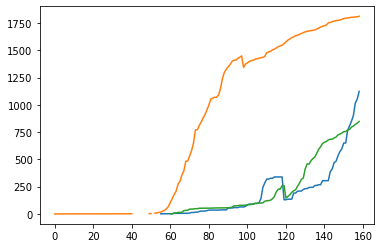

In [34]:
fig, ax = plt.subplots()
ax.plot(df[df.location == 'Benin'].total_cases.values)
ax.plot(df[df.location == 'Lithuania'].total_cases.values)
ax.plot(df[df.location == 'Uganda'].total_cases.values)

In [35]:
for features in cumulative_columns:
    df = fix_incorrect_decrease(df, features, search_threshold='match')

Fixing 20 countries in the cases column feature
Fixing 16 countries in the cases_per100k column feature
Fixing 10 countries in the confirmed_cases column feature
Fixing 10 countries in the total_cases column feature
Fixing 18 countries in the deaths column feature
Fixing 11 countries in the deaths_per100k column feature
Fixing 2 countries in the confirmed_deaths column feature
Fixing 2 countries in the total_deaths column feature
Fixing 13 countries in the tests_cumulative column feature
Fixing 13 countries in the tests_per100k column feature
Fixing 2 countries in the total_tests column feature
Fixing 2 countries in the total_tests_per_thousand column feature
Fixing 38 countries in the recovered column feature


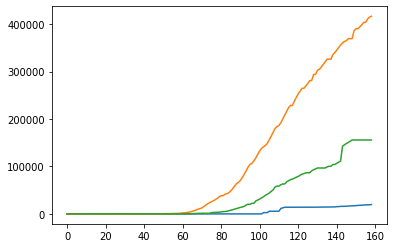

In [36]:
fig, ax = plt.subplots()
ax.plot(df[df.location == 'Benin'].tests_cumulative.values)
ax.plot(df[df.location == 'Lithuania'].tests_cumulative.values)
ax.plot(df[df.location == 'Uganda'].tests_cumulative.values)

## Preprocessing: missing values, feature production, etc.
<a id='missingval'></a>
[Return to table of contents](#toc)

The next section is concerned with the handling and imputation of missing values. The key consideration is
to not contaminate the time series with information from the future. Because I am filling in the missing values here,
I will be flagging the original missing values and keeping these flags as new features. 

My original idea was to normalize using the population of each country but I'm unsure as to whether this is the best
idea; at least without another consideration. Using the population blindly results in micro-states and small countries
being weighted heavily. Now, either I can drop these countries or I can weight the features differently; with the population *density*. This accounts for population as well as how large the state is.

## Feature production, deciding on which features to use for modeling<a id='newfeatures'></a>

In [37]:
# redundant features; some features contain the same substring but are not redundant, hence the use of .difference()
redundant_death_columns = column_search(df, 'death').difference(['cvd_death_rate'])
redundant_test_columns = column_search(df, 'test').difference(['tests_units','h2_testing_policy'])
redundant_case_columns= column_search(df, 'cases')

In [38]:
df.population_density.nunique(), df.location.nunique()

(148, 149)

In [39]:
# To prevent the SettingCopyWithSlice warning use loc, which needs index values, hence
# the application of this workaround function. 
# df.loc[country_search(df, 'Afghanistan'), 'population_density'] = 154
# df.loc[country_search(df, 'Kosovo'), 'population_density'] = 159
data.loc[country_search(df, 'South Sudan'), 'population_density'] = 20.3
df.loc[country_search(df, 'South Sudan'), 'population_density'] = 20.3
# df.loc[country_search(df, 'Guinea Bissau'), 'population'] = \
# df.loc[country_search(df, 'Guinea Bissau'), 'population'].max()

df.loc[country_search(df, 'Guinea Bissau'), 'population_density'] = \
df.loc[country_search(df, 'Guinea Bissau'), 'population_density'].max()


for country_indices in country_groupby(df):
    df.loc[country_indices, ['population','population_density']] = \
    df.loc[country_indices,  ['population','population_density']].fillna(method='ffill').fillna(method='bfill').values 

# df = df[df.population > df.population.quantile(0.1)]
per_million_population = df.population / 1000000.
population_density = df.population_density
world_pop = df[df.time_index==df.time_index.max()].population.sum()
percent_pop = df.population / world_pop
data.loc[:, 'per_million_population'] = per_million_population

Usage of custom function to fill in missing values, as well as check the validity of the time series. Mainly,
this means making sure that non-decreasing quantities in fact behave this way. It checks the difference between values $n$ and
$n+1$. If negative, the value at $n+1$ is replaced with the previous day's value. If this creates a new discrepancy, (i.e. $n+2$ is smaller then $n+1$ post-update, then it will be handled upon the next scan). Tried to make it as simple as possible to avoid any strange interactions; technically, the approximate slopes are calculated all at once and the values are updated all at once; instead of starting from the beginning and sweeping all the way through the time series. This approximation always propagates forwards, and by virtue of its calculation, always takes the larger value to be the truth. 

I will use/predict the new cases/deaths/etc. per day as opposed to the total. This avoids complications due to the cumulative
nature of the totals. For deciding which data source to actually use refer to the data exploration notebook.

In [40]:
data.loc[data.new_cases_owid<0, 'new_cases_owid'] = 0
data.loc[data.new_tests_owid<0, 'new_tests_owid'] = 0
data.loc[data.new_deaths_owid<0, 'new_deaths_owid'] = 0

# Already have a good "new tests" feature, so do not need to compute differences
df.loc[:, 'new_tests_per_million'] = (data.loc[df.index,'new_tests_testtracker'].fillna(0)/per_million_population).values
data.loc[:, 'new_tests_per_million'] = (data.loc[df.index,'new_tests_testtracker'].fillna(0)/per_million_population).values

# Already have a good "new cases" feature, so do not need to compute differences
df.loc[:, 'new_cases_per_million'] =  data.loc[df.index,'new_cases_per_million_owid'].fillna(0).values
data.loc[:, 'new_cases_per_million'] = data.loc[df.index,'new_cases_per_million_owid'].fillna(0).values

df.loc[:, 'new_deaths_per_million']  =  data.loc[df.index,'new_deaths_per_million_owid'].fillna(0).values
data.loc[:, 'new_deaths_per_million'] = data.loc[df.index,'new_deaths_per_million_owid'].fillna(0).values 

# df = fix_incorrect_decrease(df, 'recovered')
df.loc[:, 'new_recovered_per_million'] = (df.set_index(['time_index','location']).recovered.groupby(
                                            level=1).diff(1).fillna(0).values / per_million_population.values)
data.loc[:, 'new_recovered_per_million'] = (data.set_index(['time_index','location']).recovered_jhucsse.groupby(
                                            level=1).diff(1).fillna(0).values / per_million_population.values)

For completeness but unused currently.

In [41]:
df.loc[:, 'log_new_recovered_per_million'] = df.loc[:, 'new_recovered_per_million'].apply(lambda x: np.log(x+1))
df.loc[:, 'log_new_deaths_per_million']  =  df.loc[:, 'new_deaths_per_million'] .apply(lambda x: np.log(x+1))
df.loc[:, 'log_new_cases_per_million'] =  df.loc[:, 'new_cases_per_million'] .apply(lambda x: np.log(x+1))
df.loc[:, 'log_new_tests_per_million'] = df.loc[:, 'new_tests_per_million'] .apply(lambda x: np.log(x+1))

To reiterate my logic: I want or perhaps need to normalize the data. If I normalize simply on a "per million people" basis,
small micro-states such as San Marino will take on disproportionate values. I could drop these countries or look
for other weighting techniques; I opt for the latter method. The other two options I explore are weighting by population density, and weighting by the percentage of the world's population that each country comprises. The goal is to find a normalization which captures how hard individual countries have been hit but also the possible future downside, which
is of course is dependent upon how many people live in a country.

Also, the time-series of countries which have caught more cases overall will likely have better reporting practices and
be closer to the actual behavior of the virus transmission. Visual inspection of certain time series leads me to believe
they will simply act as noise, obfuscating the average or "actual" behavior. 

The current per capita weighting gives undue influence to microstate nations such as San Marino, as their population is
only a small fraction of 1 million. Therefore, remove the countries in the bottom 10 percent (arbitrary) of populations. 

Now that the features of importance have been created, can drop the remaining redundant/cumulative information from the DataFrame.

In [42]:
df_pruned = df.drop(columns=(redundant_death_columns.tolist() 
                         + redundant_test_columns.tolist() 
                         + redundant_case_columns.tolist()+['recovered']))

assumed_to_be_better_stringency_index = df_pruned.loc[:, 'stringency_index'].isna().sum().argmin()
stringency = df_pruned.loc[:, 'stringency_index'].iloc[:, assumed_to_be_better_stringency_index]

df_pruned = df_pruned.drop(columns=['country_name', 'country_code',
                                                    'm1_wildcard','stringency_index_for_display',
                                                   'stringency_legacy_index', 'stringency_legacy_index_for_display',
                                                    'government_response_index_for_display',
                                                    'containment_health_index_for_display',
                                                    'economic_support_index_for_display',
                                                    'iso_code','stringency_index'])
df_pruned.loc[:, 'stringency_index'] = stringency.values

Personal preference of reordered the DataFrame. 

In [43]:
indexers = ['location','date','time_index','days_since_first_case']
new_per_million_quantity_features = ['new_cases_per_million',
            'new_tests_per_million', 
            'new_recovered_per_million', 
            'new_deaths_per_million']
log_new_per_million_quantity_features = ['log_new_cases_per_million',
            'log_new_tests_per_million', 
            'log_new_recovered_per_million', 
            'log_new_deaths_per_million']
flag_features = column_search(df_pruned,'flag')
time_independent_features =df_pruned.loc[:, 'population':'hospital_beds_per_thousand'].columns.tolist()
time_dependent_features = df_pruned.loc[:, 'c1_school_closing':'economic_support_index'].columns.difference(flag_features).tolist()+['stringency_index']
flag_features = flag_features.tolist()+['tests_units']

Reorder the DataFrame for personal preference.

In [44]:
df_reorder = df_pruned.loc[:, indexers
                              +log_new_per_million_quantity_features
                              +new_per_million_quantity_features
                              +time_dependent_features
                              +time_independent_features
                              +flag_features]

The flag columns take values 1.0, 0.0, np.nan. 
Convert these to categorical, and for the sake of column names map floats to str.
Afterwards, drop the column that corresponds to missing values to remove collinearity. 

In [45]:
flag_df = df_reorder.loc[:, flag_features].fillna('Missing').astype('category')
for col in flag_df.columns:
    flag_df.loc[:, col] = flag_df.loc[:, col].cat.rename_categories({1.0 : '1', 0. : '0'})
    
flag_dummies = pd.get_dummies(flag_df)
flag_dummies_without_collinearity = flag_dummies[flag_dummies.columns[~flag_dummies.columns.str.contains('Missing')]]
df_reorder = pd.concat((df_reorder.drop(columns=flag_features),
                        flag_dummies_without_collinearity),axis=1)

missing_flags = df_reorder.iloc[:,np.where(df_reorder.isna().sum() > 0)[0]].isna().astype(int)
missing_flags.columns = missing_flags.columns + '_missing_flag'

for country_indices in country_groupby(df_reorder):
    fill_tmp = df_reorder.loc[country_indices, time_independent_features].fillna(method='ffill').fillna(method='bfill')
    df_reorder.loc[country_indices, time_independent_features] = fill_tmp.values
    df_reorder.loc[country_indices, time_dependent_features] = df_reorder.loc[country_indices, time_dependent_features].fillna(method='ffill').fillna(value=0)
df_reorder.loc[:, time_independent_features] = df_reorder.loc[:, time_independent_features].fillna(df_reorder.loc[:, time_independent_features].median())
df = regularize_names(df_reorder).copy()

One-hot columns for the location categorical variable.

In [46]:
location_dummies_without_collinearity = pd.get_dummies(df.location, drop_first=True)
location_dummies_without_collinearity.columns += '_flag'
location_dummies_without_collinearity = regularize_names(location_dummies_without_collinearity)

Because I'm going to impute values for the time independent features, it may or may not be important to track this by flagging
the missing values via one-hot encoding. Note that I have just manipulated the flagging columns so that *their* missing value flags are not included; but again this is because of linear dependency reasons. 

For time independent features, do not have to be careful with time; because there is no two-sided fillna method that
I am aware of, handle this by filling forwards and backwards.

Time dependent features can only be filled forward so that information from the future is not visible from the past. Additionally, any other missing values are filled with 0's; only other options would be, for instance, the mean up to that date. 

# Feature production

In [47]:
# Majority 
# This handles "time dependency" which is step-function like. 
# time_dependent_features = list(np.array(time_dependent_features)[(df.loc[:, time_dependent_features].nunique() > 10).values])
# time_dependent_features

In [48]:
oxcgrt_index_variables = df.loc[:,column_search(df,'index')].columns[1:].intersection(
                   pd.Index(time_dependent_features)).tolist()

In [49]:
df = df.loc[:, indexers 
                  + log_new_per_million_quantity_features
                  + new_per_million_quantity_features 
                  + time_dependent_features
                  + time_independent_features
                 ].copy()

df = pd.concat((df, location_dummies_without_collinearity, missing_flags),axis=1)


Create the moving averages of the time dependent features to attempt to convey the time dependence to the regression models. 

In [50]:
# use multiples of 7 to capture weekly seasonality
roll_widths = [7,14,21,28]

new_features_list = rolling_means(df, 
                                  new_per_million_quantity_features
                                  +time_dependent_features, 
                                  roll_widths=roll_widths)
new_features = pd.concat(new_features_list, axis=1)

export_to_modeling = pd.concat((df,
                                new_features
                               ),axis=1)
export_to_modeling.to_csv('regression_data.csv')

Want the CNN to create the features, only include the data on the "new" quantities.

In [51]:

cnn_features =  (indexers 
                +new_per_million_quantity_features 
                )
               
cnn_df = df.loc[:, cnn_features]
cnn_df.to_csv('cnn_data.csv')

The one-hot encoded columns and even the government response time series may introduce noise due to their
piecewise-constant nature of their values. Just in-case, create a version of the regression data without these
features.

In [52]:
# changing the values to better respect 
df_pruned_numerical = df_pruned.copy()
df_tmp = df_pruned_numerical.loc[:, new_per_million_quantity_features].replace(to_replace=0., value=np.nan)
for country_indices in country_groupby(df_pruned_numerical):
    df_tmp.loc[country_indices, :] = df_tmp.loc[country_indices, :].fillna(method='ffill').fillna(value=0)
df_pruned_numerical.loc[:, new_per_million_quantity_features] = df_tmp.values

df_reorder_numerical = df_pruned_numerical.loc[:, indexers
                              +new_per_million_quantity_features
                                          ]

In [53]:
df_numerical = regularize_names(df_reorder_numerical).copy()

In [54]:
roll_widths = [7,14,21,28]

regression_df = df_numerical.loc[:, indexers 
                 + new_per_million_quantity_features 
                      ].copy()

new_features_list = rolling_features(regression_df, 
                                  new_per_million_quantity_features,
                                  roll_widths=roll_widths)

export_to_modeling = pd.concat((regression_df,
                                new_features_list,
                               ),axis=1)

In [55]:
export_to_modeling.to_csv('regression_data_numerical.csv')

In [56]:
time_slice(data,-1,-1).new_tests_owid

157        NaN
316        NaN
475        NaN
634        NaN
793        NaN
         ...  
23053      NaN
23212      NaN
23371      NaN
23530      NaN
23689    464.0
Name: new_tests_owid, Length: 149, dtype: float64